# HistFactory

`pyhf` stands for **py**thon-based **H**ist**F**actory.

It's a tool for statistical analysis of data in High Energy Physics.

In this chapter, we will cover
* What HistFactory is in general
* What pyhf is specifically (and what it is not)

## Statistical Analysis

We divide analyses into the type of fit being performed:
* unbinned analysis (based on individual observed events)
* binned analyses (based on aggregation of events)

<center>
    <img alt="WHgamgam unbinned distribution" src="https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/SUSY-2018-23/fig_04d.png" width=300 style="display: inline" />
    <img alt="SUSY MBJ binned distribution" src="https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/CONFNOTES/ATLAS-CONF-2018-041/fig_08a.png" width=400 style="display: inline" />
</center>

Like HistFactory, `pyhf` does not work with unbinned analyses. These will not be covered in the tutorial.

So what uses HistFactory?
* TRexFitter
* WSMaker
* HistFitter

Most everyone in SUSY and Exotics who performs an asymptotic fit as part of their analysis is likely using HistFactory!

### Why Binned?

Most likely, one performs a binned analysis if no functional form of the p.d.f. is known. Instead, you make approximations (re: educated guesses) as to this functional form through histograms.

What is a histogram? Fundamentally, a histogram is a tool to bookkeep arrays of numbers:
* binning
* counts
* errors

Beyond that, it contains lots of other magic ingredients to make them more user-friendly for common operations (addition, division, etc...).

## What are the ingredients?

Once you have a model, you can perform inference such as
* exclusion fit (upper limits)
* discovery fit (lower limits)
* measurement (two-sided intervals)
* parameter scans
* impact plots
* pull plots
* ...

<img src="https://raw.githubusercontent.com/scikit-hep/pyhf/master/docs/_static/img/README_1bin_example.png" alt="common operation - parameter scan" width=400 />

Let's make up some samples and histograms to go along with it to understand what's going on. Suppose we have an analysis with expected event rate $\lambda$ and measurements $n$. For this incredibly simple case, the overall probability of the full experiment is the **joint probability** of each bin:

$$
p(n|\lambda) = \prod_{\mathrm{bin}\ b} \mathrm{Pois}(n_b | \lambda_b)
$$

Why Poisson? This is a counting experiment after all. A region we want to model will then just be a series of Poissons.

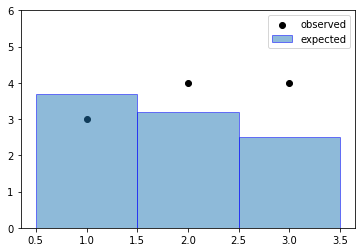

In [1]:
import matplotlib.pyplot as plt

bins = [1,2,3]
observed = [3, 4, 4]
expected_yields = [3.7, 3.2, 2.5]

fig, ax = plt.subplots()
ax.bar(bins, expected_yields, 1.0, label=r'expected', edgecolor='blue', alpha=0.5)
ax.scatter(bins, [3, 4, 4], color='black', label='observed')
ax.set_ylim(0,6)
ax.legend();

However, we don't always often have just a single (MC) sample, and $\lambda$ is often the sum of multiple sample yields

$$
\lambda = \sum_{\mathrm{sample}\ s} \lambda_s
$$

A typical case might be multiple (sub)dominant backgrounds or having a model where the observed events are described by a signal + background p.d.f. Then the p.d.f. might look like

$$
p(n|\lambda) = \prod_{\mathrm{bin}\ b} \mathrm{Pois}(n_b | \lambda_b) \qquad \lambda_b = \sum_{\mathrm{sample}\ s} \lambda_{bs}
$$

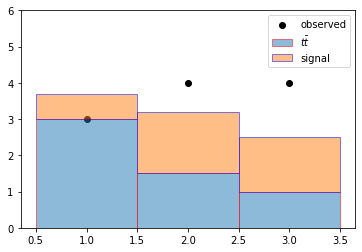

In [2]:
bins = [1,2,3]
observed = [3, 4, 4]
background = [3.0, 1.5, 1.0]
signal = [0.7, 1.7, 1.5]

fig, ax = plt.subplots()
ax.bar(bins, background, 1.0, label=r'$t\bar{t}$', edgecolor='red', alpha=0.5)
ax.bar(bins, signal, 1.0, label=r'signal', edgecolor='blue', bottom=background, alpha=0.5)
ax.scatter(bins, [3, 4, 4], color='black', label='observed')
ax.set_ylim(0,6)
ax.legend();

Already, you can see the p.d.f. for this simple case starts expanding to be a little bit more generic, and a little bit more flexible. Now we want to incorporate when the expected yields for signal and backgrounds depend on some **parameters**, perhaps how we applied calibrations to some objects, or how we configured our Monte-Carlo generators, etc...

Suppose we wanted a $\mu_s$ that is a normalization factor scaling up (or down!) the sample. For example, if we want to parametrize the signal strength (without changing background). So $\lambda$ becomes a function of $\theta = \{\mu\}$ (a set of the parameters that determine the expected event rate), then our p.d.f. expands to be

$$
p(n|\lambda(\mu)) = \prod_{\mathrm{bin}\ b} \mathrm{Pois}(n_b | \lambda_b(\theta)) \qquad \lambda_b(\theta) = \sum_{\mathrm{sample}\ s} \lambda_{bs}(\theta)
$$

where $\mu_{\mathrm{background}} = 1$

signal: [0.7, 1.7, 1.5]
background: [3.0, 1.5, 1.0]
observed: [3, 4, 4]



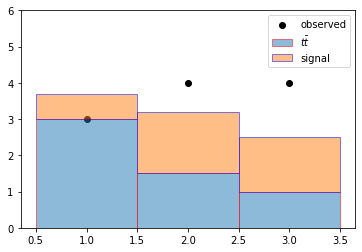

In [3]:
import ipywidgets as widgets

@widgets.interact(mu=(0, 5, 0.1))
def draw_plot(mu=1):
    bins = [1,2,3]
    observed = [3, 4, 4]
    background = [3.0, 1.5, 1.0]
    signal = [i*mu for i in [0.7, 1.7, 1.5]]

    print(f'signal: {signal}')
    print(f'background: {background}')
    print(f'observed: {observed}\n')
    
    fig, ax = plt.subplots()
    ax.bar(bins, background, 1.0, label=r'$t\bar{t}$', edgecolor='red', alpha=0.5)
    ax.bar(bins, signal, 1.0, label=r'signal', edgecolor='blue', bottom=background, alpha=0.5)
    ax.scatter(bins, [3, 4, 4], color='black', label='observed')
    ax.set_ylim(0,6)
    ax.legend();

One final thing to finish our build up of a simplified p.d.f. is about **auxiliary measurements**. What we mean is that perhaps the background sample is modeled by some normalization parameter, but we've also performed additional measurements in a separate analysis that constraints the parametrization (e.g. Jet Energy Scale) so we have stronger confidence that the true parameter is within a certain range.

For some parameters in a statistical model, all we have to infer its values is the given analysis. These parameters are **unconstrained** ($\eta$):

$$
p(n | \lambda(\theta))
$$

For many parameters, we have the **auxiliary data** ($a$) given as an *auxiliary measurement* which is added to the main p.d.f.. These parameters are **constrained** ($\chi$).

$$
p_\chi(a | \chi)
$$

where $\theta = \{\eta, \chi\}$. This constraining function can generally be anything, but most of the time in HistFactory - it's a Gaussian or a Poisson. The p.d.f. expands to be

$$
p(n,a|\lambda(\theta)) = \prod_{\mathrm{bin}\ b} \mathrm{Pois}(n_b | \lambda_b(\theta)) \prod_{\mathrm{constraint}\ \chi} p_\chi(a_\chi | \chi) \qquad \lambda_b(\theta) = \sum_{\mathrm{sample}\ s} \lambda_{bs}(\theta)
$$

For this simple example, let's consider a Gaussian centered at $\mu=0$ with $\sigma=1$ for constraining the normalization on the background where an up-variation ($\mu_b = +1$) scales by 1.3, and a down-variation ($\mu_b = -1$) scales by 0.8.

signal: [0.7, 1.7, 1.5]
background: [3.0, 1.5, 1.0]
observed: [3, 4, 4]
likelihood scaled by: 1.0



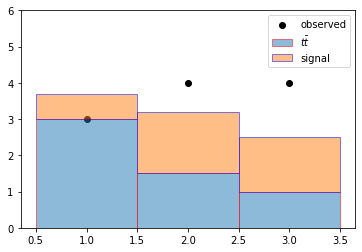

In [4]:
import numpy as np
from scipy.stats import norm

def gaussian_constraint(mu_b=0.0):
    return norm.pdf(mu_b, loc=0.0, scale=1.0)

# interpolating
def interpolate(down,nom,up,alpha):
    if alpha >= 0:
        return (up-nom)*alpha + 1
    else:
        return 1 - (down-nom)*alpha
    
@widgets.interact(mu=(0, 5, 0.1), mu_b=(-1, 1, 0.1))
def draw_plot(mu=1, mu_b=0):
    bins = [1,2,3]
    observed = [3, 4, 4]
    background = [i*interpolate(0.8, 1.0, 1.3, mu_b) for i in [3.0, 1.5, 1.0]]
    signal = [i*mu for i in [0.7, 1.7, 1.5]]

    print(f'signal: {signal}')
    print(f'background: {background}')
    print(f'observed: {observed}')
    print(f'likelihood scaled by: {gaussian_constraint(mu_b)/gaussian_constraint(0.0)}\n')
    
    fig, ax = plt.subplots()
    ax.bar(bins, background, 1.0, label=r'$t\bar{t}$', edgecolor='red', alpha=0.5)
    ax.bar(bins, signal, 1.0, label=r'signal', edgecolor='blue', bottom=background, alpha=0.5)
    ax.scatter(bins, [3, 4, 4], color='black', label='observed')
    ax.set_ylim(0,6)
    ax.legend();

But that's not all! Notice that all along, we've been only discussing a single "channel" with 3 bins. The statistical analysis being studied might involve **multiple channels** corresponding to different signal regions and control regions. Therefore, we compute the likelihood as

$$
p_\text{main} = p_\text{channel1} * p_\text{channel2} * p_\text{channel3} \cdots
$$

So in fact, we can then expand out the likelihood definition further

$$
p(n,a|\theta) = \underbrace{\prod_{\mathrm{channel}\ c}\prod_{\mathrm{bin}\ b} \mathrm{Pois}(n_{cb} | \lambda_{cb}(\theta))}_{\text{main}} \underbrace{\prod_{\mathrm{constraint}\ \chi} p_\chi(a_\chi | \chi)}_{\text{auxiliary}} \qquad \lambda_{cb}(\theta) = \sum_{\mathrm{sample}\ s} \lambda_{cbs}(\theta)
$$

As you can see, this is sort of a bookkeeping problem. We have two pieces of this likelihood:
* our main model, which consists of
  * several channels (regions, histograms, etc), where
  * each channel is a set of simultaneous Poissons measuring the bin count against an expected value, where
  * the expected value is the sum of various samples, where
  * each samples expected value can be a function of parameters (or modifiers)
* the constraint model, which consists of
  * several auxiliary measurements, where
  * each measurement comes with auxiliary data
  
It should be clear by now that this is quite a lot of pieces to keep track of. This is where HistFactory comes in to play. Using HistFactory, we can
* describe observed event rates and expected event rates
* use well-defined **modifiers** to express parameterizations of the expected event rates
* use well-defined **interpolation** mechanisms to derive expected event rates (if needed)
* automatically handle auxiliary measurements / additional constraint terms

*Note: if you're curious about interpolation and interesting challenges, see the next chapter.*

## pyhf


Up to about 2 years ago, HistFactory was only implemented using ROOT, RooStats, RooFit (+ minuit). pyhf provides two separate pieces:
* a schema for serializing the HistFactory workspace in plain-text formats, such as JSON
* a toolkit that interacts and manipulates the HistFactory workspaces

Why is this crucial? HistFactory in ROOT is a combination of loosely-linked XML+ROOT files
* XML for structure
* ROOT for storing data

These would then be processed through a `hist2workspace` command to get the ROOT Workspace that RooStats/RooFit use. As an example, let's look at the provided multichannel HistFactory XML+ROOT as part of this tutorial:

In [5]:
!ls -lhR data/multichannel_histfactory

data/multichannel_histfactory:
total 8.0K
drwxr-xr-x 2 feickert feickert 4.0K Sep 25 01:43 config
drwxr-xr-x 2 feickert feickert 4.0K Sep 25 01:43 data

data/multichannel_histfactory/config:
total 20K
-rw-r--r-- 1 feickert feickert  974 Sep 25 01:43 example_control.xml
-rw-r--r-- 1 feickert feickert 1.1K Sep 25 01:43 example_signal.xml
-rw-r--r-- 1 feickert feickert  906 Sep 25 01:43 example.xml
-rw-r--r-- 1 feickert feickert 6.4K Sep 25 01:43 HistFactorySchema.dtd

data/multichannel_histfactory/data:
total 8.0K
-rw-r--r-- 1 feickert feickert 5.9K Sep 25 01:43 data.root


Here, we have two folders:

* `config` which provides
  * the XML HistFactory schema [`HistFactorySchema.dtd`](./data/multichannel_histfactory/config/HistFactorySchema.dtd)
  * a top-level [`example.xml`](./data/multichannel_histfactory/config/example.xml)
  * signal region and control region structures
* `data` which provides the stored histograms in [`data.root`](./data/multichannel_histfactory/data/data.root)

Let's just look at the XML structure for now. What does the top-level look like?

In [6]:
!cat -n data/multichannel_histfactory/config/example.xml

     1	<!--
     2	//============================================================================
     3	// Name        : example.xml
     4	//============================================================================
     5	-->
     6	
     7	<!--
     8	    Top-level configuration,  details for the example channel are in example_channel.xml.
     9	    This is the input file to the executable.
    10	
    11	    Note: Config.dtd needs to be accessible.  It can be found in ROOT release area.
    12	    The file system path is relative to location of this XML file, not the executable.
    13	-->
    14	
    15	<!DOCTYPE Combination  SYSTEM 'HistFactorySchema.dtd'>
    16	
    17	<Combination OutputFilePrefix="./results/example">
    18	  <Input>./config/example_signal.xml</Input>
    19	  <Input>./config/example_control.xml</Input>
    20	  <Measurement Name="GaussExample" Lumi="1." LumiRelErr="0.1" ExportOnly="True">
    21	    <POI>SigXsecOverSM</POI>
    22	    <ParamSetting Const

This top-level specifies:
* 15: the HistFactory XML schema
* 17: the workspace definition
* 18,19: channel definitions (links to other files)
* 20: a measurement `GaussExample` with specifications for luminosity, the parameter of interest, and setting `lumi` constant

What does the signal region look like?

In [7]:
!cat -n data/multichannel_histfactory/config/example_signal.xml

     1	<!--
     2	    Single channel configuration exampple.
     3	    The top level configuration XML is example.xml
     4	
     5	    NormalizedByTheory should be "True" (not "TRUE" or "true") for all non-data-driven backgrounds.
     6	
     7	    If you comment or remove the <Data> tag then it will use the expected data.
     8	
     9	    Histogram inputs should be in pb and in top-level xml the lumi should be in 1/pb
    10	    (The important thing is that they match... fb and 1/fb is also ok)
    11	
    12	    Note: Config.dtd needs to be accessible.  It can be found in ROOT release area.
    13	    The file system path is relative to location of this XML file, not the executable.
    14	-->
    15	
    16	<!DOCTYPE Channel  SYSTEM 'HistFactorySchema.dtd'>
    17	
    18	<Channel Name="channel1" InputFile="./data/data.root" >
    19	  <Data HistoName="signal_data" HistoPath="" />
    20	  <Sample Name="signal" HistoPath="" HistoName="signal_signal">
    21	    <NormFactor Na

This signal region specifies:
* 16: the HistFactory XML schema
* 18: the channel definition along with the path to the file for where the data for this channel is stored
* 19: where the expected event rate (data) for this channel is located
* 20, 23: sample definitions for `signal` and `bkg` with each sample expected event rate stored under `HistoName` in the corresponding ROOT file
* 21: a parameter `SigXsecOverSM` which is an unconstrained normalization factor
* 24: a parameter `uncorrshape_signal` which is a Poisson-constrained shape systematic, with the corresponding auxiliary data stored under `HistoName` in the corresponding ROOT file

As you can see, this works fine. It's a little bulky, and a lot of loosely-tied information, but this fulls specifies the HistFactory model we've discussed so far.

In the next chapter, we'll learn how to use `pyhf` to convert to the HistFactory JSON representation.